In [33]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pickle

ImportError: cannot import name 'DecisionTreeClassifier' from 'sklearn.linear_model' (C:\Users\ilyap\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\__init__.py)

# Загрузка данных

In [2]:
data_path = r"../data/bankruptcy_data.csv"
data = pd.read_csv(data_path, index_col=0)

In [ ]:
data.head(10)

In [6]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2846300 entries, 0 to 3104783
Data columns (total 40 columns):
 #   Column                                             Non-Null Count    Dtype  
---  ------                                             --------------    -----  
 0   Наименование                                       2846300 non-null  object 
 1   Регистрационный номер                              2846300 non-null  float64
 2   Код налогоплательщика                              2846300 non-null  float64
 3   Вид деятельности/отрасль                           2846300 non-null  object 
 4   Код основного вида деятельности                    2846300 non-null  object 
 5   Организационно-правовая форма                      2846300 non-null  object 
 6   Форма собственности                                2846300 non-null  object 
 7   Размер компании                                    2846258 non-null  object 
 8   Важная информация                                  337634 non-

# Обработка данных

In [3]:
def preprocess_data(data):

    data.reset_index(inplace = True, drop=True)
    
    # Удаление ненужных столбцов
    data.drop(["Наименование", "Регистрационный номер", "Код налогоплательщика", "Код основного вида деятельности"], axis = 1, inplace = True)
    
    # Перевод категориальных признаков в числовые
    data["Вид деятельности/отрасль"] = data["Вид деятельности/отрасль"].astype("category").cat.codes
    data["Организационно-правовая форма"] = data["Организационно-правовая форма"].astype("category").cat.codes
    data["Форма собственности"] = data["Форма собственности"].astype("category").cat.codes
    data["Размер компании"] = data["Размер компании"].astype("category").cat.codes

    # Заполнение пропусков
    data.fillna(0, inplace = True)
    # Преобразование признака Важная информация
    data["Важная информация"].where(data["Важная информация"] == 0, other = 1, inplace = True)
    data["Важная информация"] = data["Важная информация"].astype("int8")
    
    #Уменьшение числа строк
    data_nonzero = data.loc[(data["Банкротство"] != 0)]
    data_zero = data.loc[(data["Банкротство"] == 0)]
    data_zero = data_zero.sample(frac=1).reset_index(drop=True)
    rows_num = np.round(data_nonzero.shape[0]*0.25) # 25% от числа ненулевых строк для баланса данных
    data_zero = data_zero.loc[:rows_num, :]
    data = pd.concat([data_nonzero, data_zero], axis=0).sample(frac=1).reset_index(drop=True)
    print(rows_num)
    print(data.info())
    
    # Отделение целевого признака
    X = data.drop("Банкротство", axis = 1)
    y = data["Банкротство"]
    
    return X, y

In [4]:
X, y = preprocess_data(data)

5245.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26226 entries, 0 to 26225
Data columns (total 36 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Вид деятельности/отрасль                           26226 non-null  int16  
 1   Организационно-правовая форма                      26226 non-null  int8   
 2   Форма собственности                                26226 non-null  int8   
 3   Размер компании                                    26226 non-null  int8   
 4   Важная информация                                  26226 non-null  int8   
 5   Год                                                26226 non-null  int64  
 6   Основные средства , RUB                            26226 non-null  float64
 7   Внеоборотные активы, RUB                           26226 non-null  float64
 8   Запасы, RUB                                        26226 non-null  float64
 9  

In [5]:
def split_data(X, y, train_size):

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size)

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split_data(X, y, 0.7)

# Обучение модели

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

In [20]:
# model = LogisticRegression(penalty = "l2", solver="lbfgs", multi_class = "ovr", 
#                            n_jobs = 3, verbose = 1).fit(X_train, y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:    3.6s finished


In [58]:
model = DecisionTreeClassifier().fit(X_train, y_train)

In [42]:
#model = RandomForestClassifier(criterion = "gigni", max_depth).fit(X_train, y_train)

# Оценка модели

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [59]:
y_train_result = model.predict(X_train)
y_test_result = model.predict(X_test)

In [60]:
y_test_proba = model.predict_proba(X_test)
print(y_test_proba[:10])

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [61]:
print(f"Train precision: {precision_score(y_true = y_train, y_pred = y_train_result, average = 'weighted')}")
print(f"Train recall: {recall_score(y_true = y_train, y_pred = y_train_result, average = 'weighted')}")
print(f"Train F1: {f1_score(y_true = y_train, y_pred = y_train_result, average = 'weighted')}\n")

print(f"Test precision: {precision_score(y_true = y_test, y_pred = y_test_result, average = 'weighted')}")
print(f"Test recall: {recall_score(y_true = y_test, y_pred = y_test_result, average = 'weighted')}")
print(f"Test F1: {f1_score(y_true = y_test, y_pred = y_test_result, average = 'weighted')}")


Train precision: 0.9988021302342395
Train recall: 0.9988016123760758
Train F1: 0.9988016338992786

Test precision: 0.83943926163715
Test recall: 0.8357905439755974
Test F1: 0.8375249190081218


In [62]:
nonzero_data = np.where(y_test != 0)
nonzero_data_num = np.array(nonzero_data).reshape(-1).shape[0]
print(f"{nonzero_data_num} ненулевых целевых значений в тестовом датасете")

nonzero_result = np.where(y_test_result != 0)
nonzero_result_num = np.array(nonzero_result).reshape(-1).shape[0]
print(f"{nonzero_result_num} предсказанных ненулевых целевых значений")
print(f"Доля предсказанных ненулевых целевых значений {nonzero_result_num/nonzero_data_num:.3f}")

6322 ненулевых целевых значений в тестовом датасете
6278 предсказанных ненулевых целевых значений
Доля предсказанных ненулевых целевых значений 0.993


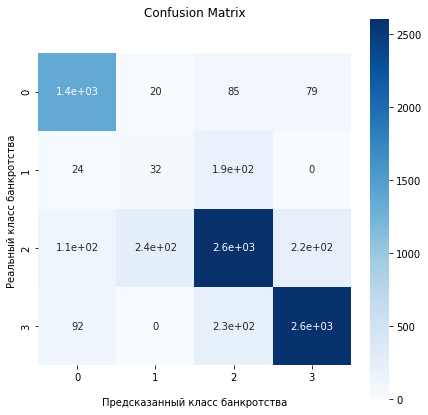

In [63]:
cf_matrix = confusion_matrix(y_test, y_test_result)

plt.figure(figsize=(7,7))

ax = sn.heatmap(cf_matrix, annot=True, cmap='Blues', square = True)

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nПредсказанный класс банкротства')
ax.set_ylabel('Реальный класс банкротства ');


ax.xaxis.set_ticklabels(['0','1', '2', '3'])
ax.yaxis.set_ticklabels(['0','1', '2', '3'])

plt.show()

In [14]:
def plot_weights(weights,names,model_type):
    

    feature_weights = np.array(weights)
    feature_names = np.array(names)
    

    data={'feature_names':feature_names,'feature_weights':feature_weights}
    fi_df = pd.DataFrame(data)
    

    fi_df.sort_values(by=['feature_weights'], ascending=False,inplace=True)
    

    plt.figure(figsize=(20,40))

    sn.barplot(x=fi_df['feature_weights'], y=fi_df['feature_names'])

    plt.title(model_type + ' Weights')
    plt.xlabel('Weights')
    plt.ylabel('Feature names')

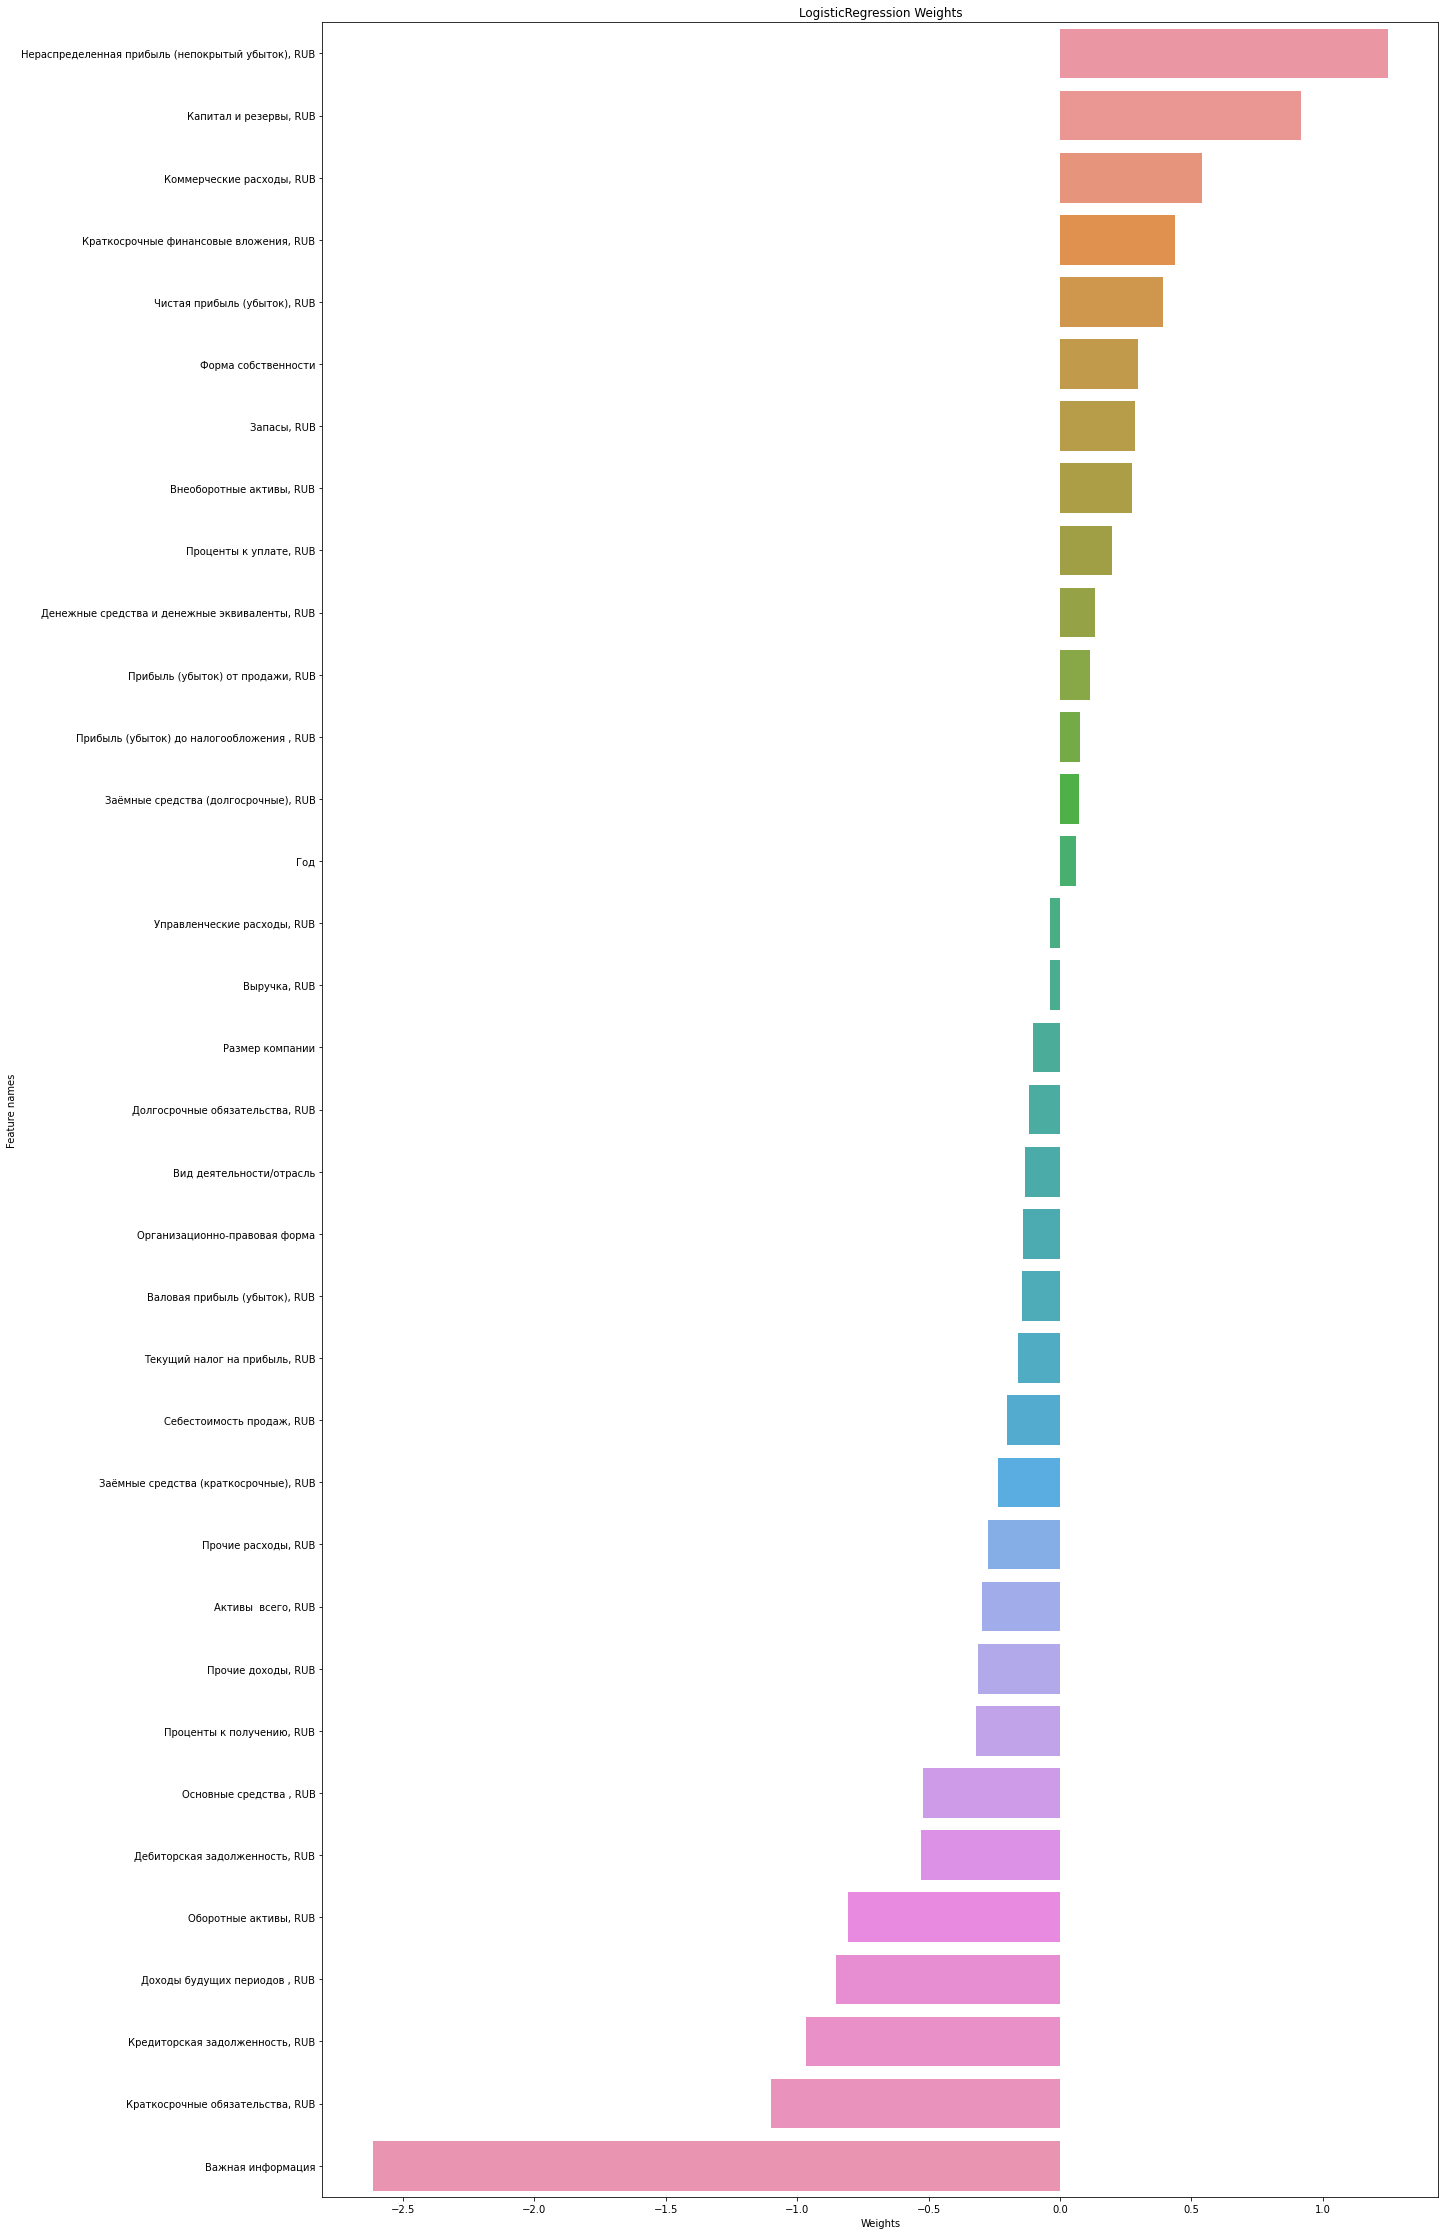

In [15]:
plot_weights(model.coef_[0], data.drop("Банкротство", axis = 1).columns, "LogisticRegression")

# Сохранение модели

In [9]:
with open('../model/best_model.pkl','wb') as f:
    pickle.dump(model, f)